In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
df = pd.read_csv("C:\\AJCE\\vehicle_maintenance_data.csv")
df.head()

,Vehicle_Model,Mileage,Maintenance_History,Reported_Issues,Vehicle_Age,Fuel_Type,Transmission_Type,Engine_Size,Odometer_Reading,Last_Service_Date,Warranty_Expiry_Date,Owner_Type,Insurance_Premium,Service_History,Accident_History,Fuel_Efficiency,Tire_Condition,Brake_Condition,Battery_Status,Need_Maintenance
0,Truck,58765,Good,0,4,Electric,Automatic,2000,28524,2023-11-23,2025-06-24,Second,20782,6,3,13.622204,New,New,Weak,1
1,Van,60353,Average,1,7,Electric,Automatic,2500,133630,2023-09-21,2025-06-04,Second,23489,7,0,13.625307,New,New,Weak,1
2,Bus,68072,Poor,0,2,Electric,Automatic,1500,34022,2023-06-27,2025-04-27,First,17979,7,0,14.306302,New,Good,Weak,1
3,Bus,60849,Average,4,5,Petrol,Automatic,2500,81636,2023-08-24,2025-11-05,Second,6220,7,3,18.709467,New,Worn Out,New,1
4,Bus,45742,Poor,5,1,Petrol,Manual,2000,97162,2023-05-25,2025-09-14,Third,16446,6,2,16.977482,Good,Good,Weak,1


In [9]:
# Print original columns to verify
print("Original Dataset Columns:")
print(df.columns.tolist())

Original Dataset Columns:
['Vehicle_Model', 'Mileage', 'Maintenance_History', 'Reported_Issues', 'Vehicle_Age', 'Fuel_Type', 'Transmission_Type', 'Engine_Size', 'Odometer_Reading', 'Last_Service_Date', 'Warranty_Expiry_Date', 'Owner_Type', 'Insurance_Premium', 'Service_History', 'Accident_History', 'Fuel_Efficiency', 'Tire_Condition', 'Brake_Condition', 'Battery_Status', 'Need_Maintenance']


In [10]:
# Data preprocessing
# 1. Convert dates to days since last service
df['Last_Service_Date'] = pd.to_datetime(df['Last_Service_Date'])
df['Warranty_Expiry_Date'] = pd.to_datetime(df['Warranty_Expiry_Date'])
df['Days_Since_Last_Service'] = (pd.Timestamp.now() - df['Last_Service_Date']).dt.days

In [11]:
# 2. Drop unnecessary columns
columns_to_drop = [
    'Last_Service_Date',
    'Warranty_Expiry_Date',
    'Insurance_Premium',
    'Fuel_Efficiency',
    'Owner_Type',
    'Battery_Status',
    'Vehicle_Age'
]
df = df.drop(columns_to_drop, axis=1)

In [13]:
# 3. Handle categorical variables
# Label encoding for binary/ordinal variables
le_dict = {}
categorical_cols = ['Maintenance_History', 'Fuel_Type', 'Transmission_Type']
for col in categorical_cols:
    le_dict[col] = LabelEncoder()
    df[col] = le_dict[col].fit_transform(df[col])

# One-hot encoding for nominal variables
nominal_cols = ['Vehicle_Model', 'Tire_Condition', 'Brake_Condition']
df = pd.get_dummies(df, columns=nominal_cols)

In [14]:
# 4. Scale numerical features
scaler = StandardScaler()
numerical_features = [
    'Mileage',
    'Odometer_Reading',
    'Days_Since_Last_Service',
    'Engine_Size',
    'Service_History',
    'Accident_History'
]
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [15]:
# Save the scaler
print("\nSaving preprocessing objects...")
joblib.dump(scaler, 'ml_model/scaler.pkl')


Saving preprocessing objects...


['ml_model/scaler.pkl']

In [16]:
# Prepare features and target
X = df.drop('Need_Maintenance', axis=1)
y = df['Need_Maintenance']

# Split the data
print("\nSplitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
print("\nTraining Random Forest model...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
rf_model.fit(X_train, y_train)


Splitting data into train and test sets...

Training Random Forest model...


RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

In [19]:
# Make predictions
print("\nMaking predictions...")
y_pred = rf_model.predict(X_test)

# Print model performance
print("\nModel Performance Metrics:")
print("-" * 50)
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Making predictions...

Model Performance Metrics:
--------------------------------------------------
Model Accuracy: 0.8859

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.83      0.74      1915
           1       0.96      0.90      0.93      8085

    accuracy                           0.89     10000
   macro avg       0.81      0.87      0.83     10000
weighted avg       0.90      0.89      0.89     10000



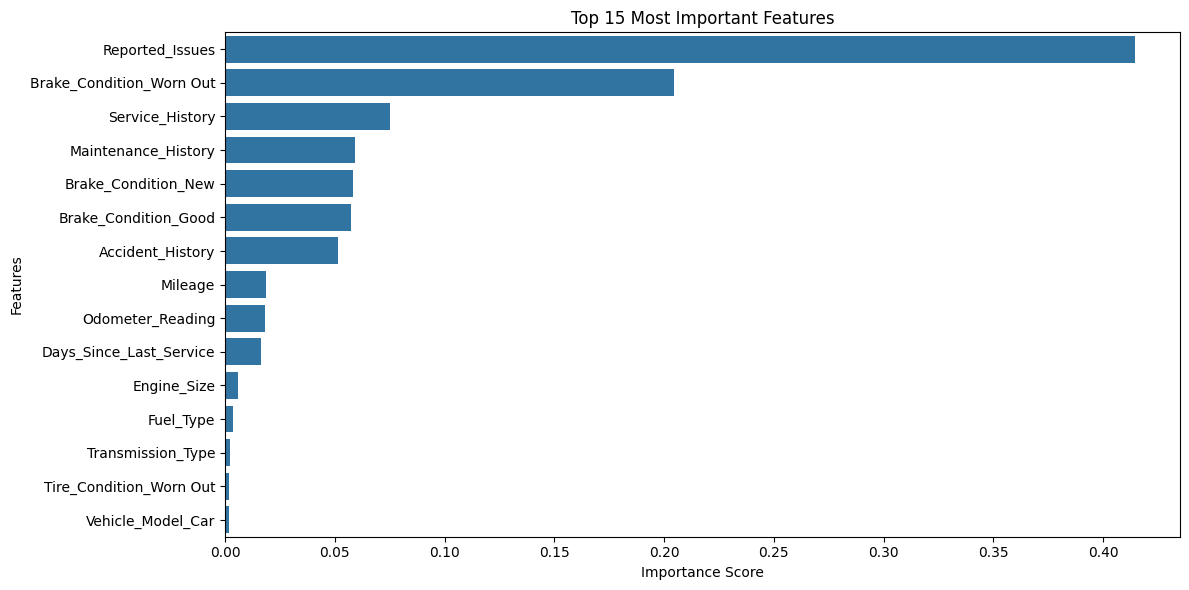

In [20]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('ml_model/feature_importance.png')
plt.show()

In [21]:
# Save the model and preprocessing info
joblib.dump(rf_model, 'ml_model/predictive_maintenance_model.pkl')

['ml_model/predictive_maintenance_model.pkl']

In [22]:
joblib.dump(le_dict, 'ml_model/label_encoders.pkl')

['ml_model/label_encoders.pkl']

In [23]:
# Save feature names
with open('ml_model/feature_names.txt', 'w') as f:
    f.write('\n'.join(X.columns.tolist()))

print("\nModel and feature names saved successfully!")


Model and feature names saved successfully!


In [24]:
# Create detailed model summary
print("\nCreating model summary...")
with open('ml_model/model_summary.txt', 'w') as f:
    f.write("Predictive Maintenance Model Summary\n")
    f.write("-" * 50 + "\n\n")
    
    f.write("1. Model Performance\n")
    f.write(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n\n")
    
    f.write("2. Classification Report\n")
    f.write(classification_report(y_test, y_pred))
    f.write("\n")
    
    f.write("3. Feature Importance (Top 10)\n")
    for i, row in feature_importance.head(10).iterrows():
        f.write(f"{row['feature']}: {row['importance']:.4f}\n")
    
    f.write("\n4. Model Configuration\n")
    f.write("- Algorithm: Random Forest Classifier\n")
    f.write("- Number of trees: 100\n")
    f.write("- Max depth: 10\n")
    f.write(f"- Number of features: {len(X.columns)}\n")
    f.write(f"- Training set size: {len(X_train)}\n")
    f.write(f"- Test set size: {len(X_test)}\n")

print("\nFinal Feature List:")
print("-" * 50)
for i, feature in enumerate(X.columns, 1):
    print(f"{i}. {feature}")

print("\nModel training and evaluation completed successfully!")
print("All files saved in the 'ml_model' directory.")


Creating model summary...

Final Feature List:
--------------------------------------------------
1. Mileage
2. Maintenance_History
3. Reported_Issues
4. Fuel_Type
5. Transmission_Type
6. Engine_Size
7. Odometer_Reading
8. Service_History
9. Accident_History
10. Days_Since_Last_Service
11. Vehicle_Model_Bus
12. Vehicle_Model_Car
13. Vehicle_Model_Motorcycle
14. Vehicle_Model_SUV
15. Vehicle_Model_Truck
16. Vehicle_Model_Van
17. Tire_Condition_Good
18. Tire_Condition_New
19. Tire_Condition_Worn Out
20. Brake_Condition_Good
21. Brake_Condition_New
22. Brake_Condition_Worn Out

Model training and evaluation completed successfully!
All files saved in the 'ml_model' directory.
